# 0. IMPORTS

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import pickle

# Data visualization and organisation
import inflection
from tabulate        import tabulate
from IPython.display import Image

# metrics
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics         import confusion_matrix

# feature engineering
from sklearn                 import preprocessing
from scipy.stats             import chi2_contingency
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder

# pre-modelling
from sklearn.model_selection import train_test_split

# feature selection
from sklearn.ensemble        import RandomForestClassifier

# machine learning models
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier
from lightgbm                import LGBMClassifier

# cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# hyperparameter fine tuning
from sklearn.model_selection import RandomizedSearchCV

# model performance
from sklearn.metrics         import auc, precision_recall_curve
from scikitplot.metrics      import plot_lift_curve, plot_cumulative_gain

# Sileting warnings
import warnings
warnings.filterwarnings("ignore")

## 0.1. Reading Files

In [2]:
df = pd.read_csv('data/churn.csv')

## 0.2. Helper Functions

In [3]:
# Graph visualization

from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# For showing percentages in plt.countplot

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [5]:
# Cramer V for categorical variables correlation

def cramer_v(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Crosstab building
    chi2 = chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1) 
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [6]:
# Classification Machine Learning Algorithms performance (Accuracy / Precision / Recall / F1 / AUC-ROC)

def ml_performance(model_name, y, yhat):
    accuracy = accuracy_score(y, yhat)
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    roc_auc = roc_auc_score(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': accuracy, 
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1,
                         'AUC ROC': roc_auc}, index = [0])

In [7]:
# Cross-Validation performance

def cross_validation(model_name, model, x, y, cv):
    cv_accuracy = cross_val_score(model, x, y, cv = cv, scoring = 'accuracy', n_jobs = -1)
    cv_precision = cross_val_score(model, x, y, cv = cv, scoring = 'precision', n_jobs = -1)
    cv_recall = cross_val_score(model, x, y, cv = cv, scoring = 'recall', n_jobs = -1)
    cv_f1 = cross_val_score(model, x, y, cv = cv, scoring = 'f1', n_jobs = -1)
    cv_roc_auc = cross_val_score(model, x, y, cv = cv, scoring = 'roc_auc', n_jobs = -1)
    
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': '{:.4f} +/- {:.4f}'.format(cv_accuracy.mean(), cv_accuracy.std()),
                         'Precision': '{:.4f} +/- {:.4f}'.format(cv_precision.mean(), cv_precision.std()),
                         'Recall': '{:.4f} +/- {:.4f}'.format(cv_recall.mean(), cv_recall.std()),
                         'F1 Score': '{:.4f} +/- {:.4f}'.format(cv_f1.mean(), cv_f1.std()),
                         'AUC ROC': '{:.4f} +/- {:.4f}'.format(cv_roc_auc.mean(), cv_roc_auc.std()) }, index = [0])

In [8]:
# Knapsack

# W: weight constraint
# wt: weight of each item
# val: value of each item
def knapsack(W, wt, val):
    n = len(val) # number of items in val
    # set a Table "K" with all values equal zero
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    # loop in rows of Table "K"
    for i in range(n + 1):
        # loop in columns of Table "K"
        for w in range(W + 1):
            if i == 0  or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    
    # select chosen items that maximizes the output value
    # create a list with 'n' False items
    keep = [False] * n
    res = max_val
    w = W
    # decrescent loop
    for i in range(n, 0, -1):
        if res <= 0: break # break statement terminates the loop
        # continue statement skips the rest of the code inside a loop for the current iteration only.
        # Loop does not terminate but continues on with the next iteration.
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

# 1. DESCRIBE DATA

In [9]:
df1 = df.copy()

## 1.1. Rename Columns

In [10]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
            'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

#CamelCase to snake_case
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data dimensions

In [11]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 10000
Number of columns: 14


## 1.3. Data Types

In [12]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Change DataType

In [11]:
df1[['has_cr_card', 'is_active_member', 'exited']] = df1[['has_cr_card', 'is_active_member', 'exited']].astype(bool)
df1[['customer_id', 'row_number']] = df1[['customer_id', 'row_number']].astype('object')

## 1.6. Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.6.1. Numerical Variables

In [30]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean()).round(2)
ct2 = pd.DataFrame(num_attributes.median()).round(2)

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std()).round(2)
d2 = pd.DataFrame(num_attributes.min()).round(2)
d3 = pd.DataFrame(num_attributes.max()).round(2)
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min()).round(2)
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# Concatenation
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)

df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
credit_score,650.53,652.00,96.65,350.00,850.00,500.00,-0.071607,-0.425726
age,38.92,37.00,10.49,18.00,92.00,74.00,1.011320,1.395347
tenure,5.01,5.00,2.89,0.00,10.00,10.00,0.010991,-1.165225
balance,76485.89,97198.54,62397.41,0.00,250898.09,250898.09,-0.141109,-1.489412
num_of_products,1.53,1.00,0.58,1.00,4.00,3.00,0.745568,0.582981
estimated_salary,100090.24,100193.92,57510.49,11.58,199992.48,199980.90,0.002085,-1.181518


### 1.6.2. Categorical Variables

In [81]:
cat_attributes.head()

,row_number,customer_id,surname,geography,gender,has_cr_card,is_active_member,exited
0,1,15634602,Hargrave,France,Female,True,True,True
1,2,15647311,Hill,Spain,Female,False,True,False
2,3,15619304,Onio,France,Female,True,False,True
3,4,15701354,Boni,France,Female,False,False,False
4,5,15737888,Mitchell,Spain,Female,True,True,False


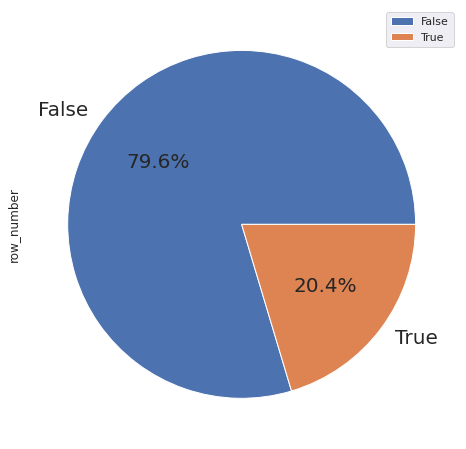

In [51]:
# data = df1[['row_number', 'gender']].groupby('gender').count()
# data.plot.pie(y = 'row_number', autopct = '%.1f%%', textprops = {'fontsize': 20});

# data = df1[['row_number', 'geography']].groupby('geography').count()
# data.plot.pie(y = 'row_number', autopct = '%.1f%%', textprops = {'fontsize': 20});

# data = df1[['row_number', 'has_cr_card']].groupby('has_cr_card').count()
# data.plot.pie(y = 'row_number', autopct = '%.1f%%', textprops = {'fontsize': 20});

# data = df1[['row_number', 'is_active_member']].groupby('is_active_member').count()
# data.plot.pie(y = 'row_number', autopct = '%.1f%%', textprops = {'fontsize': 20});

data = df1[['row_number', 'exited']].groupby('exited').count()
data.plot.pie(y = 'row_number', autopct = '%.1f%%', textprops = {'fontsize': 20});

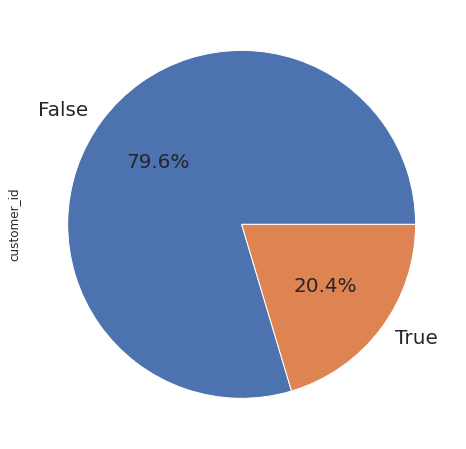

In [18]:
# # exited
# plt.subplot = (3, 2, 5)
data = df1.groupby('exited')['customer_id'].count()
data.plot.pie(autopct = '%.1f%%', subplots = True, textprops = {'fontsize': 20});

# 2. FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

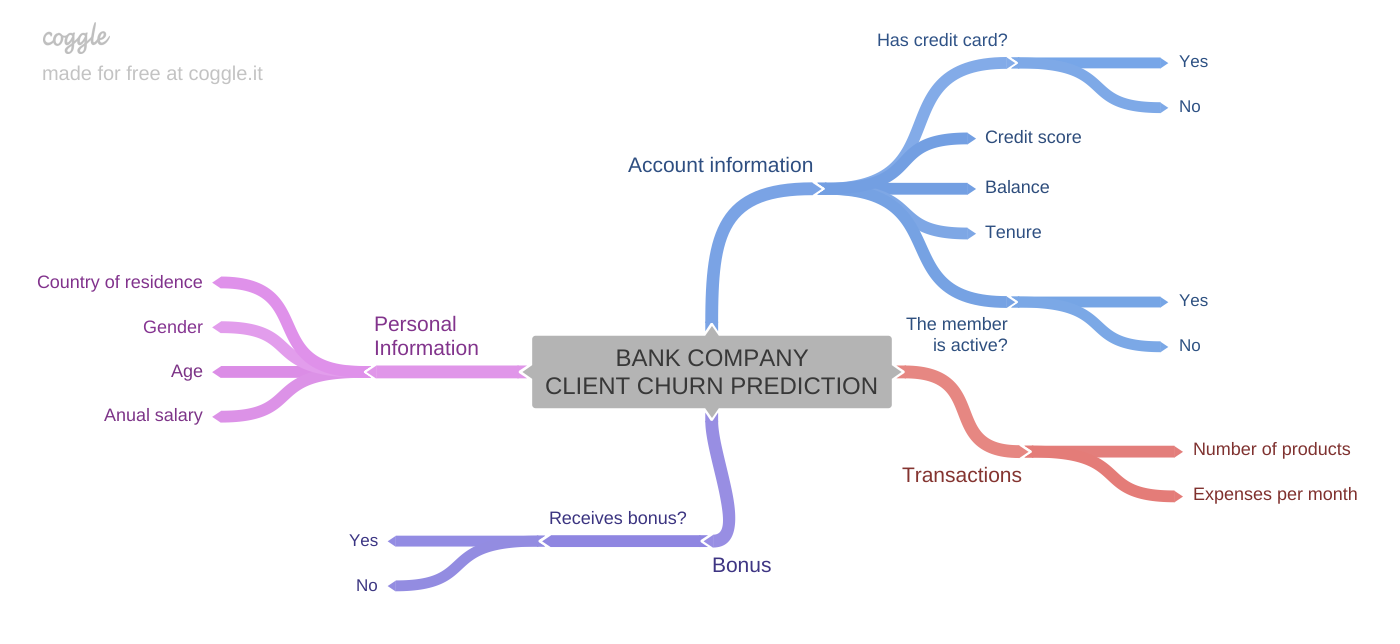

In [176]:
Image(filename = 'img/Hypothesis_MindMap.png')

## 2.2. Hypothesis Development

### 2.2.1. Personal information

**1.** **Younger clients** are **more likely** to churn. <br>
**2.** Churn percentage does not change much between countries in Europe. <br>
**3.** Clients with **higher estimated salary** are **less likely** to churn. <br> 
**4.** There are possibly **no significant differences** between **gender** in churning. <br>

### 2.2.2. Account information

**1.** Clients with **no credit card** are **more likely** to churn. <br>
**2.** Accounts with a **balance of more than 50,000 €** are **less likely** to indicate client churning. <br>
**3.** Accounts who are **active for less than 2 years** are **more likely** to close. <br>
**4.** **Active members** are **less likely** to churn.

### 2.2.3. Transactions

**1.** Clients who **acquired more products** are **less likely** to churn. <br>
**2.** Clients who **spend more than 100 € per month** are **less likely** to churn.

## 2.3. Feature Engineering

### 2.3.1. Modified Columns
(None)

### 2.3.2. Created Columns

In [13]:
# Age group
df2['age_group'] = df2['age'].apply(lambda x: 'young_adult' if x < 40
                                         else 'middle_aged_adult' if x < 60
                                         else 'old')

# Estimated salary group
df2['estimated_salary_group'] = df2['estimated_salary'].apply(lambda x: 'low' if x < 12500
                                                                   else 'medium' if x < 50000
                                                                   else 'high')

# 3. VARIABLE FILTERING

In [14]:
df3 = df2.copy()

## 3.1. Columns Selection

In [15]:
# erase columns 'row_number', 'customer_id', 'customer_surname'
df3 = df3.drop(['row_number', 'customer_id', 'surname'], axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [16]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response variable

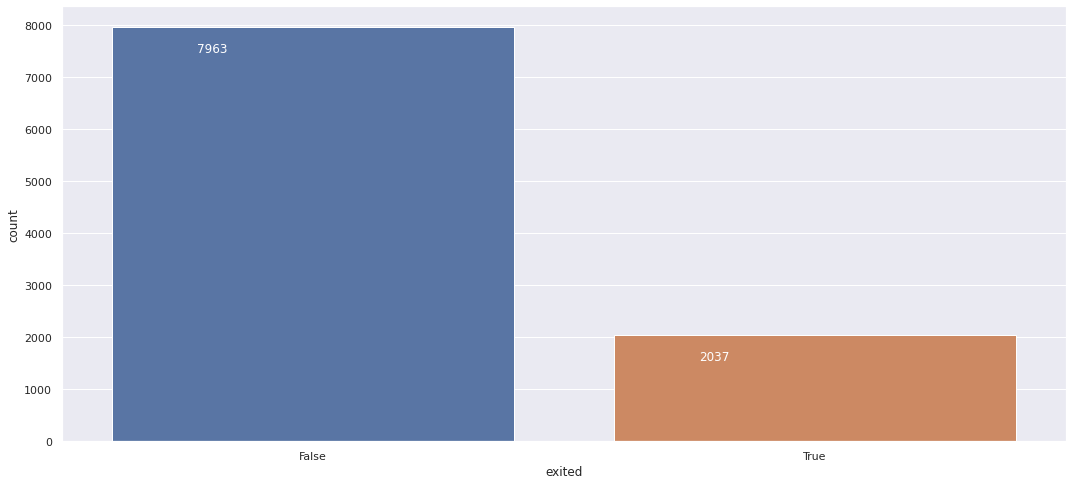

In [93]:
ax = sns.countplot(x = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

In [31]:
print('Percentage of churn clients: {} %'.format(df4[df4['exited'] == True].shape[0] / df4.shape[0] * 100))

Percentage of churn clients: 20.369999999999997 %


### 4.1.2. Numerical variables

In [172]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])

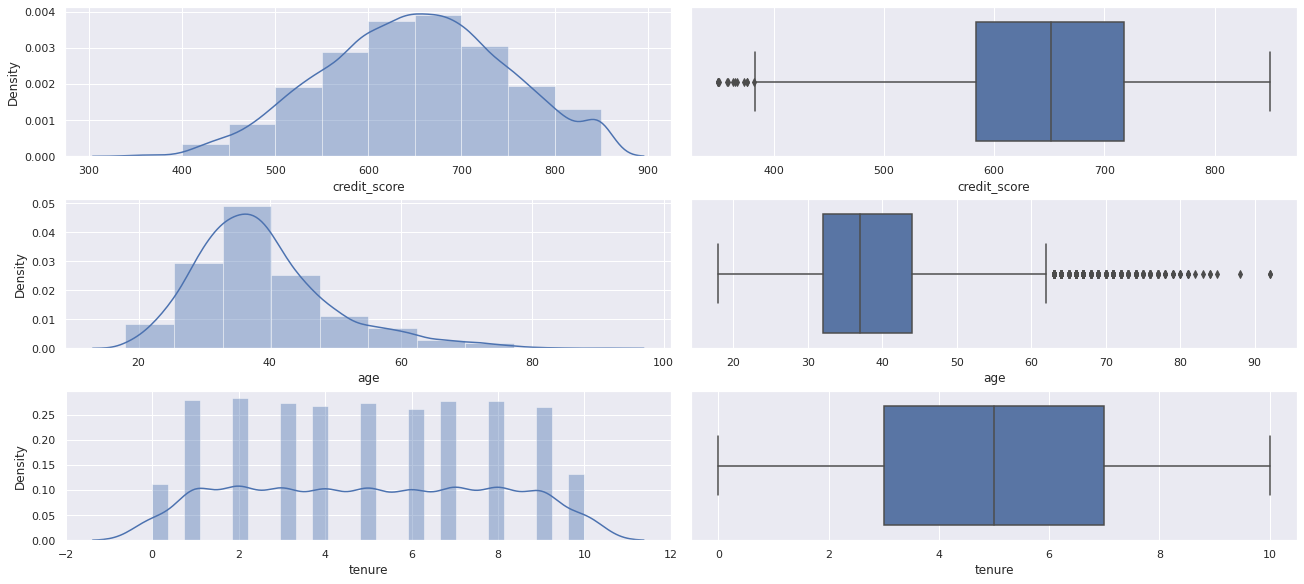

In [54]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

plt.subplot(3, 2, 1)
ax1 = sns.distplot(df4['credit_score'], bins = 10);

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(x = 'credit_score', data = df4);

plt.subplot(3, 2, 3)
ax3 = sns.distplot(df4['age'], bins = 10);

plt.subplot(3, 2, 4)
ax4 = sns.boxplot(x = 'age', data = df4);

plt.subplot(3, 2, 5)
ax5 = sns.distplot(df4['tenure']);

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(x = 'tenure', data = df4);

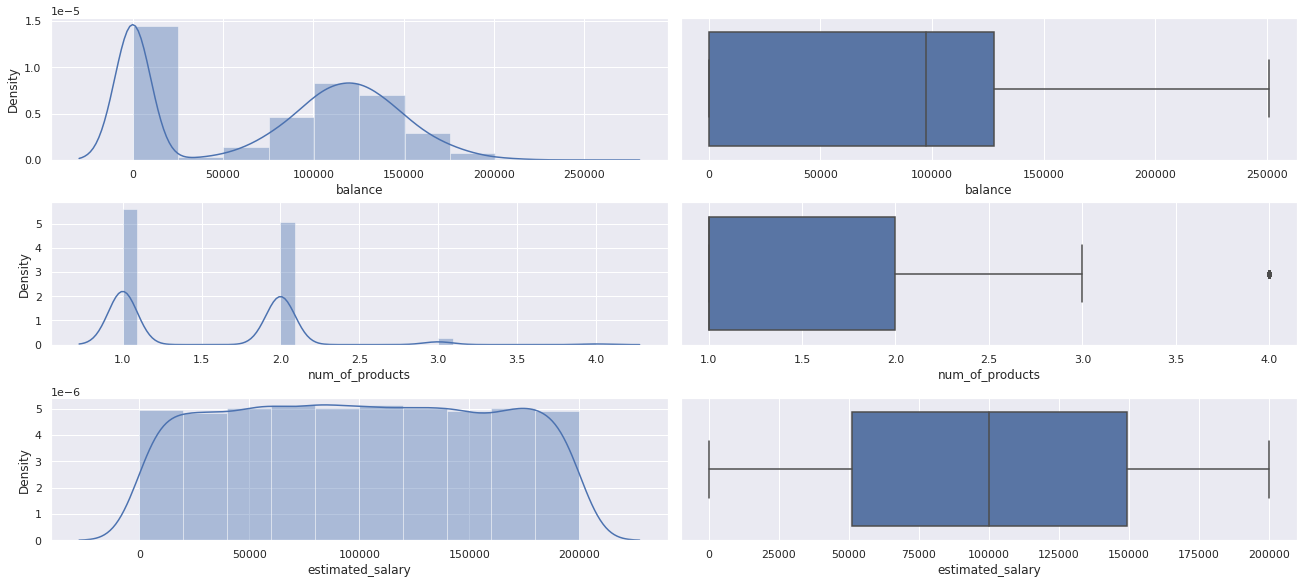

In [55]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

plt.subplot(3, 2, 1)
ax1 = sns.distplot(df4['balance'], bins = 10);

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(x = 'balance', data = df4);

plt.subplot(3, 2, 3)
ax3 = sns.distplot(df4['num_of_products']);

plt.subplot(3, 2, 4)
ax4 = sns.boxplot(x = 'num_of_products', data = df4);

plt.subplot(3, 2, 5)
ax5 = sns.distplot(df4['estimated_salary'], bins = 10);

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(x = 'estimated_salary', data = df4);

### 4.1.3. Categorical variables

In [177]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64'])
cat_attributes = cat_attributes.drop('exited', axis = 1)

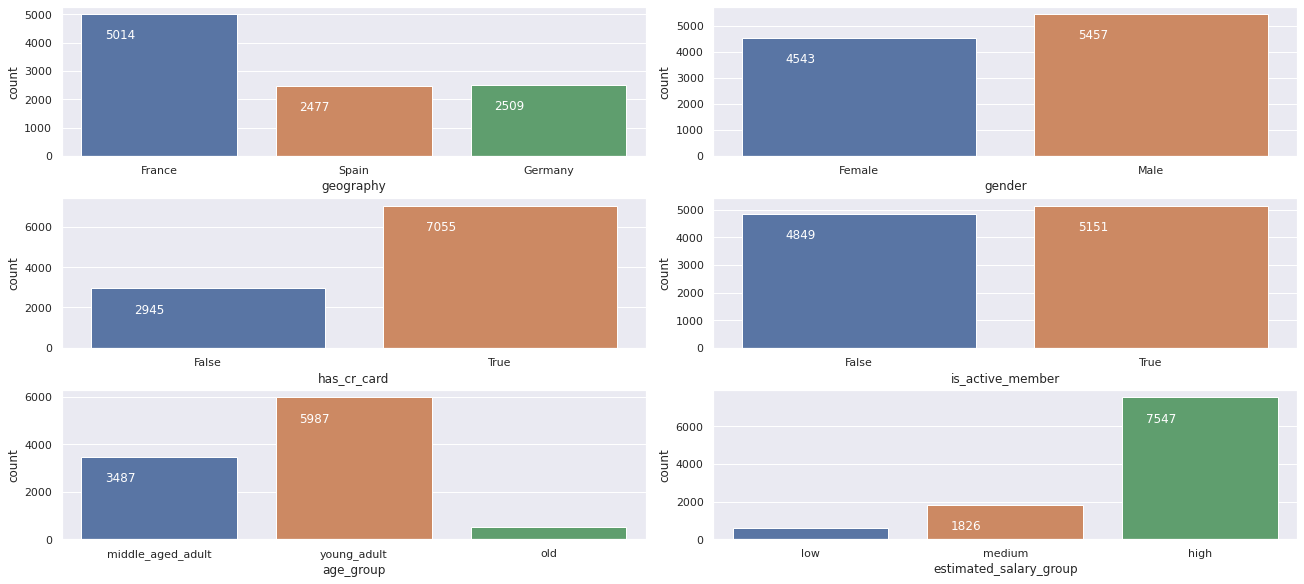

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

# geography
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x = 'geography', data = df4);
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# gender
plt.subplot(3, 2, 2)
ax2 = sns.countplot(x = 'gender', data = df4);
for p in ax2.patches:
    ax2.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# has_cr_card
plt.subplot(3, 2, 3)
ax3 = sns.countplot(x = 'has_cr_card', data = df4);
for p in ax3.patches:
    ax3.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

# is_active_member
plt.subplot(3, 2, 4)
ax4 = sns.countplot(x = 'is_active_member', data = df4);
for p in ax4.patches:
    ax4.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

# age_group
plt.subplot(3, 2, 5)
ax5 = sns.countplot(x = 'age_group', data = df4);
for p in ax5.patches:
    ax5.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# estimated_salary_group
plt.subplot(3, 2, 6)
ax5 = sns.countplot(x = 'estimated_salary_group', data = df4, order = ['low', 'medium', 'high']);
for p in ax5.patches:
    ax5.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

## 4.2. Bivariate Analysis - Hypothesis Validation

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** **Younger clients** are **more likely** to churn. <br>
**FALSE** - Middle-aged clients have a more considerable percentage of churning.

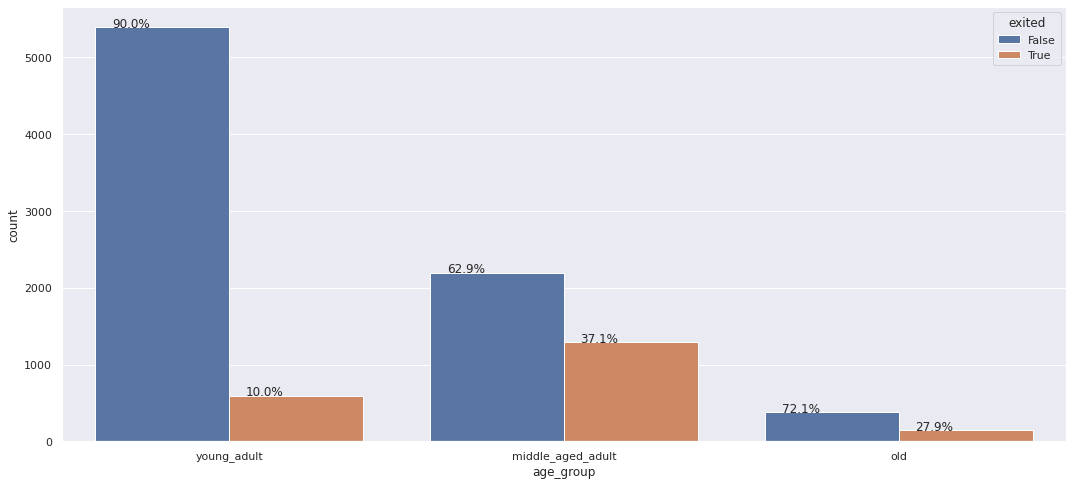

In [117]:
ax = sns.countplot(x = "age_group", hue = 'exited', data = df4, order = ['young_adult', 'middle_aged_adult', 'old']);

with_hue(ax, df4['age_group'], 3, 2)

**H2.** Churn percentage **does not change much** between **countries** in Europe. <br>
**FALSE** - It is observed a similarity in percentage between France and Spain, although Germany has a higher rate of churning.

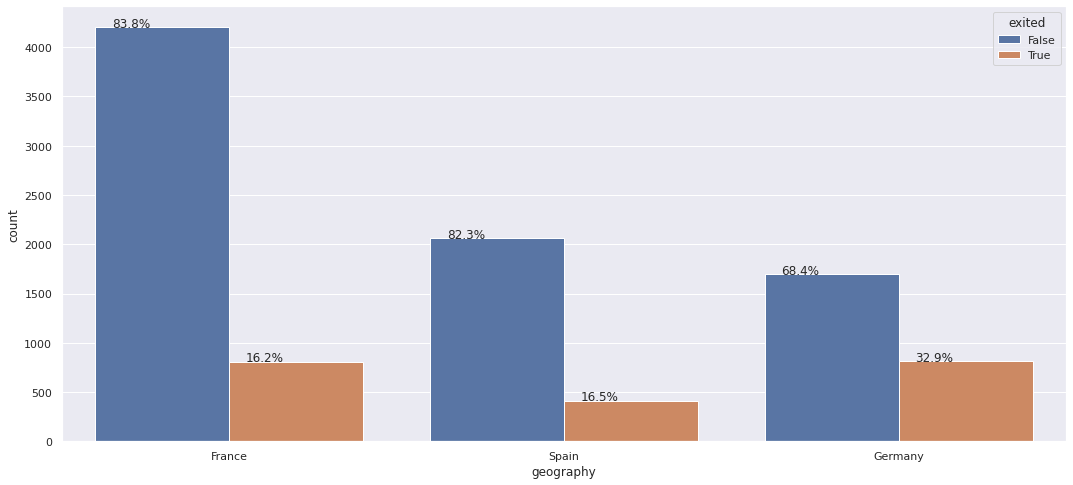

In [88]:
ax = sns.countplot(x = 'geography', hue = 'exited', data = df4);

with_hue(ax, df4['geography'], 3, 2)

**H3.** Clients with **higher estimated salary** are **less likely** to churn. <br>
**FALSE**, although percentage does not change much between categories.

In [43]:
aux1 = df4[df4['exited'] == True]

low_exited = aux1[aux1['estimated_salary_group'] == 'low'].shape[0]
medium_exited = aux1[aux1['estimated_salary_group'] == 'medium'].shape[0]
high_exited = aux1[aux1['estimated_salary_group'] == 'high'].shape[0]

#------------------------------

aux2 = df4[df4['exited'] == False]

low_not_exited = aux2[aux2['estimated_salary_group'] == 'low'].shape[0]
medium_not_exited = aux2[aux2['estimated_salary_group'] == 'medium'].shape[0]
high_not_exited = aux2[aux2['estimated_salary_group'] == 'high'].shape[0]

#------------------------------

print('Churn percentage for low salary range: {} % \n'.format(round(low_exited / (low_exited + low_not_exited)* 100, 2)))
print('Churn percentage for medium salary range: {} % \n'.format(round(medium_exited / (medium_exited + medium_not_exited)* 100, 2)))
print('Churn percentage for high salary range: {} %'.format(round(high_exited / (high_exited + high_not_exited)* 100, 2)))

Churn percentage for low salary range: 18.98 % 

Churn percentage for medium salary range: 20.26 % 

Churn percentage for high salary range: 20.51 %


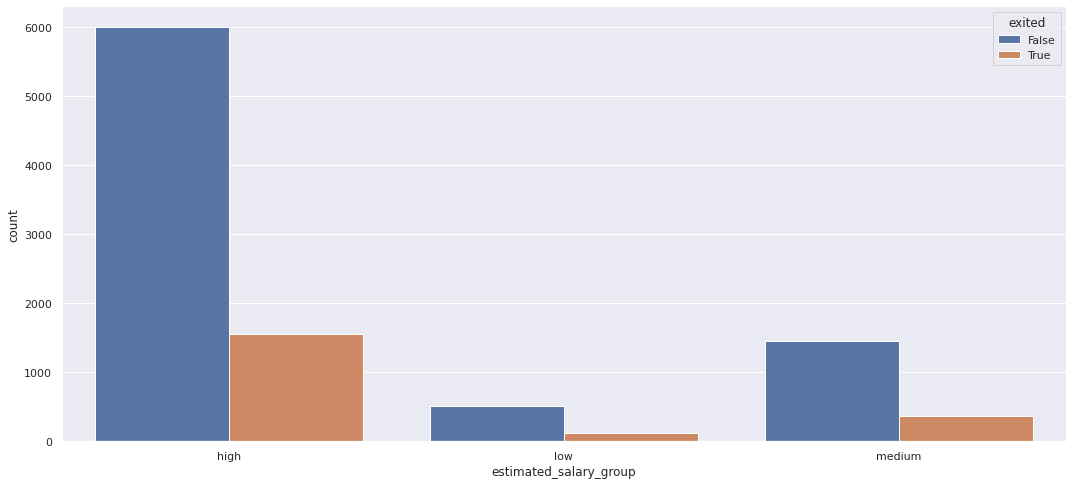

In [45]:
ax = sns.countplot(x = "estimated_salary_group", hue = 'exited', data = df4);

**H4.** There are possibly **no significant differences** between **gender** in churning. <br>
**FALSE** - The churn rate among women is significantly higher (almost 10 % more).

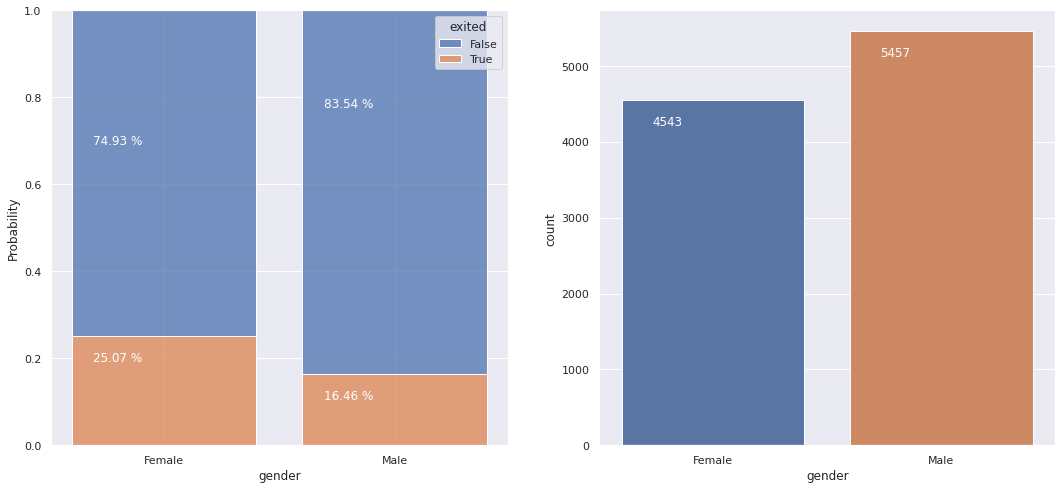

In [143]:
plt.subplot(1, 2, 1)
ax = sns.histplot(df4, x = 'gender', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'gender', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H5.** Clients with **no credit card** are **more likely** to churn. <br>
**TRUE**, although difference is not significant (less than 1 %).

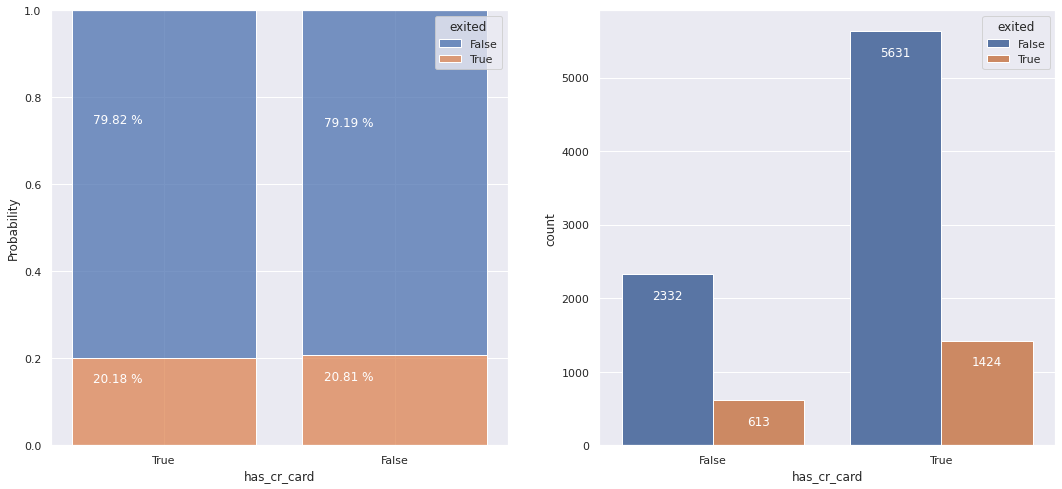

In [145]:
aux = df4.copy()

d = {True: 'True', False: 'False'}
aux['has_cr_card'] = aux['has_cr_card'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'has_cr_card', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'has_cr_card', hue = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H6.** Accounts with a **balance of more than 50,000 €** are **less likely** to indicate client churning. <br>
**FALSE**, and they do represent a significant amount of the exiting clients.

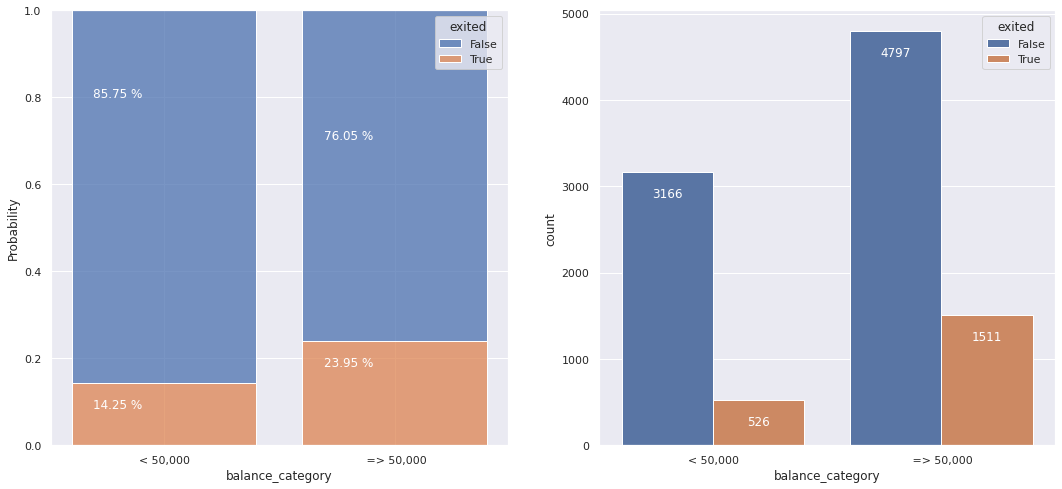

In [146]:
aux = df4.copy()

aux['balance_category'] = aux['balance'].apply(lambda x: '< 50,000' if x < 50000
                                                    else ' => 50,000')

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'balance_category', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'balance_category', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H7.** Accounts who are **active for less than 2 years** are **more likely** to close. <br>
**TRUE**, although percentage difference is not significant (approximately 1 %)

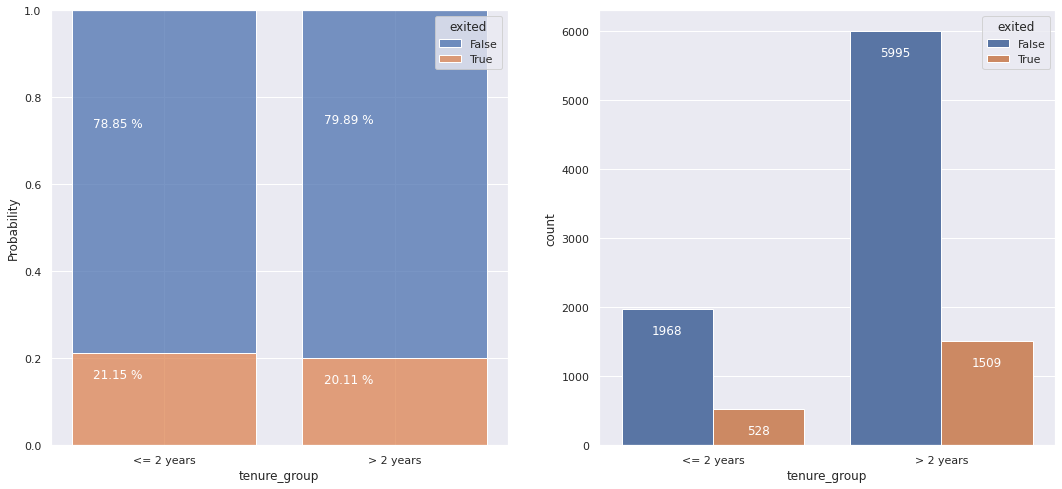

In [147]:
aux = df4.copy()

aux['tenure_group'] = aux['tenure'].apply(lambda x: '<= 2 years' if x <= 2
                                               else '> 2 years')

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'tenure_group', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'tenure_group', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H8.** **Active members** are **less likely** to churn. <br>
**TRUE**, with a percentage difference of about 13 %.

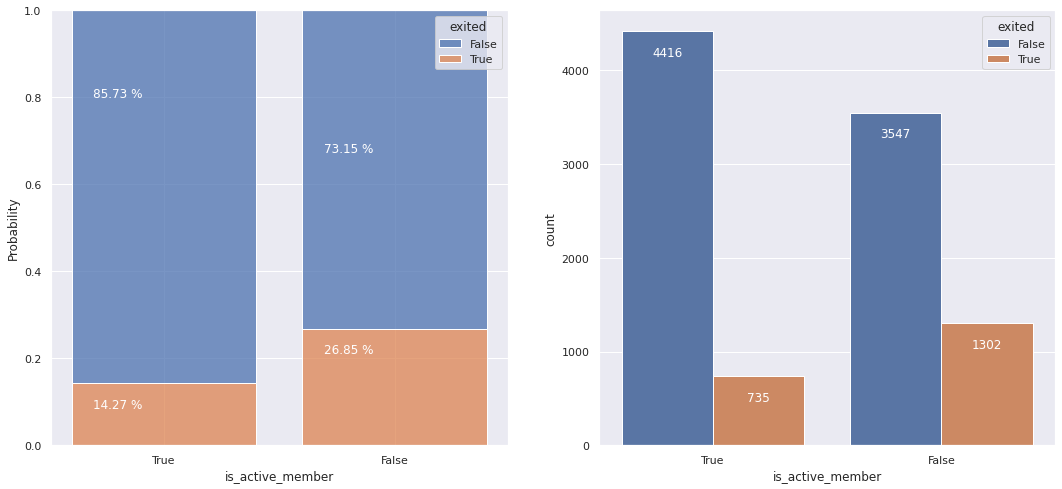

In [148]:
aux = df4.copy()

d = {True: 'True', False: 'False'}
aux['is_active_member'] = aux['is_active_member'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'is_active_member', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'is_active_member', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H9.** Clients who **acquired more products** are **less likely** to churn. <br>
**FALSE**, and the percentage of clients that acquired more than 3 bank products that exited is way higher than the ones that did not exit.

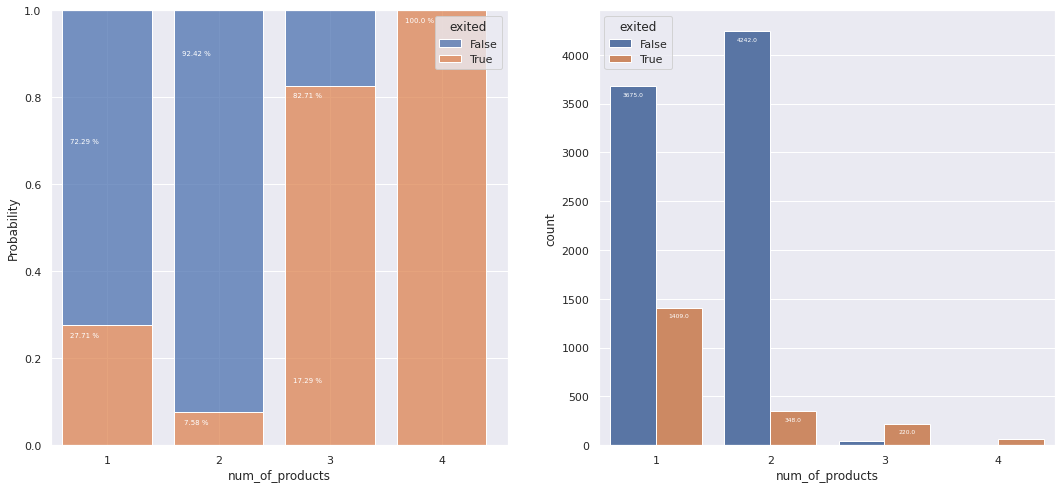

In [166]:
aux = df4.copy()

d = {1: '1', 2: '2', 3: '3', 4: '4'}
aux = aux.sort_values(by = 'num_of_products')
aux['num_of_products'] = aux['num_of_products'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'num_of_products', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 7)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'num_of_products', hue = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 6)

### 4.2.1. General Hypothesis Review

In [171]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1 - Younger clients are more likely to churn', 'False', 'High'],
       ['H2 - Churn percentage does not change much between countries in Europe', 'False', 'High'],
       ['H3 - Clients with higher estimated salary are less likely to churn', 'False', 'Low'],
       ['H4 - There are possibly no significant differences between gender in churning', 'False', 'Medium'],
       ['H5 -  Clients with no credit card are more likely to churn', 'True', 'Low'],
       ['H6 - Accounts with a balance of more than 50,000 € are less likely to indicate client churning', 'False', 'Medium'],
       ['H7 - Accounts who are active for less than 2 years are more likely to close', 'True', 'Low'],
       ['H8 - Active members are less likely to churn', 'True', 'High'],
       ['H9 - Clients who acquired more products are less likely to churn', 'False', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis                                                                                      Conclusion    Relevance
----------------------------------------------------------------------------------------------  ------------  -----------
H1 - Younger clients are more likely to churn                                                   False         High
H2 - Churn percentage does not change much between countries in Europe                          False         High
H3 - Clients with higher estimated salary are less likely to churn                              False         Low
H4 - There are possibly no significant differences between gender in churning                   False         Medium
H5 -  Clients with no credit card are more likely to churn                                      True          Low
H6 - Accounts with a balance of more than 50,000 € are less likely to indicate client churning  False         Medium
H7 - Accounts who are active for less than 2 years are more likely

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

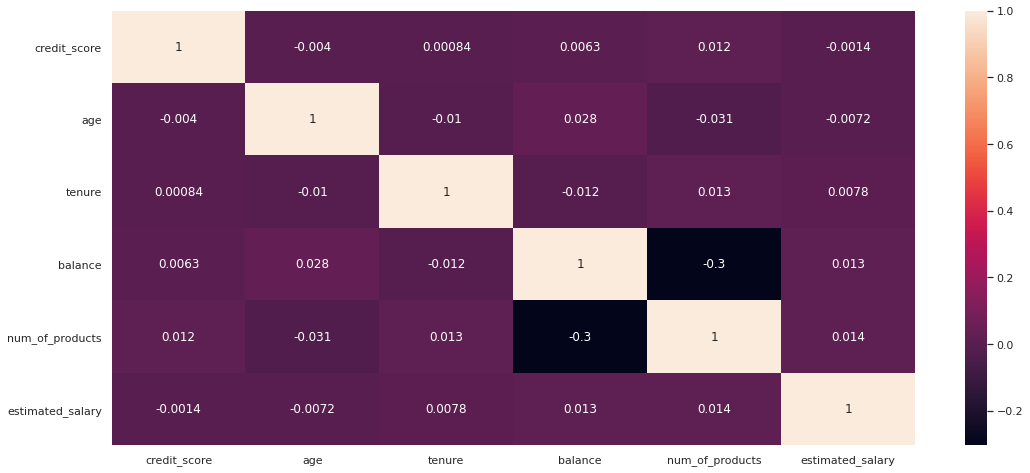

In [173]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Variables

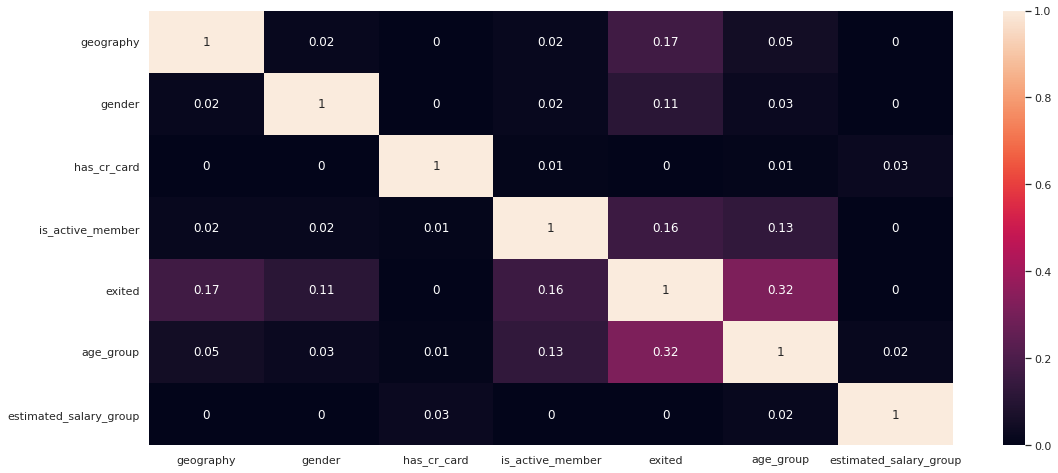

In [186]:
a = df4.select_dtypes(exclude = ['int64', 'float64'])

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in a.columns :
    data_encoded[i] = label.fit_transform(a[i])

rows = []

for var1 in data_encoded:
    col = []
    
    for var2 in data_encoded :
        cramer = cramer_v(data_encoded[var1], data_encoded[var2])
        col.append(round(cramer, 2)) 
    
    rows.append(col)
    
cramer_results = np.array(rows)
d = pd.DataFrame(cramer_results, columns = data_encoded.columns, index = data_encoded.columns)

sns.heatmap(d, annot = True);

# 5. DATA PREPARATION

In [17]:
df5 = df4.copy()

## 5.1. Rescaling

In [18]:
mms = MinMaxScaler()
rs = RobustScaler()

# MinMaxScaler for 'tenure', 'balance', 'num_of_products' & 'estimated_salary'
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
df5['balance'] = mms.fit_transform(df5[['balance']].values)
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)

# RobustScaler for 'credit_score' & 'age' (significant presence of outliers)
df5['credit_score'] = rs.fit_transform(df5[['credit_score']].values)
df5['age'] = rs.fit_transform(df5[['age']].values)

## 5.2. Encoding

In [19]:
# LabelEncoder for 'geography' & 'gender'
le = LabelEncoder()

df5['geography'] = le.fit_transform(df5['geography'])

df5['gender'] = le.fit_transform(df5['gender'])


# OrdinalEncoder for 'age_group' & 'estimated_salary_group'
assort_dict1 = {'young_adult': 1,
                'middle_aged_adult': 2,
                'old': 3}
df5['age_group'] = df5['age_group'].map(assort_dict1)

assort_dict2 = {'low': 1,
                'medium': 2,
                'high': 3}
df5['estimated_salary_group'] = df5['estimated_salary_group'].map(assort_dict2)

# 6. FEATURE SELECTION

In [20]:
df6 = df5.copy()

## 6.1. Split DataFrame into Training and Test

In [21]:
train, test = train_test_split(df6, test_size = 0.2, random_state = 42, shuffle = True)

X_train = train
y_train = X_train['exited']
X_train = X_train.drop(['exited'], axis = 1)

X_test = test
y_test = X_test['exited']
X_test = X_test.drop(['exited'], axis = 1)

## 6.2. RandomForest as Feature Selector

In [20]:
# train RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns, 'feature importance': rf.feature_importances_}).sort_values('feature importance', ascending = False).reset_index(drop = True)

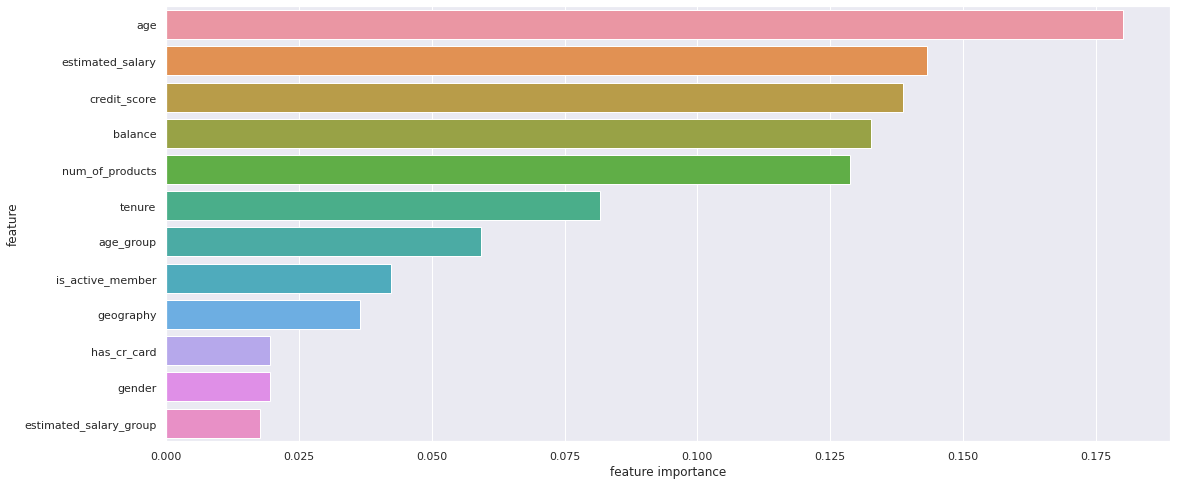

In [35]:
# Plot feature importance
sns.barplot(x = 'feature importance', y = 'feature', data = feat_imp, orient = 'h');

In [21]:
feat_imp_select = feat_imp.iloc[:9]
feat_imp_select

,feature,feature importance
0,age,0.180045
1,estimated_salary,0.143298
2,credit_score,0.138624
3,balance,0.132693
4,num_of_products,0.128801
5,tenure,0.081607
6,age_group,0.059277
7,is_active_member,0.042272
8,geography,0.036505


In [22]:
feat_imp_select['feature'].to_list()

['age',
 'estimated_salary',
 'credit_score',
 'balance',
 'num_of_products',
 'tenure',
 'age_group',
 'is_active_member',
 'geography']

## 6.3. Saving Best Features (Feature selector + EDA)

In [22]:
cols_selected = ['age',
                 'estimated_salary',
                 'credit_score',
                 'balance',
                 'num_of_products',
                 'tenure',
                 'is_active_member',
                 'geography']

# columns to add
feat_to_add = ['gender', 'exited']

# final features
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(feat_to_add)

# 7. MACHINE LEARNING MODELS

In [25]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

In [26]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [27]:
# Defining Cross-Validation strategy
cv = StratifiedKFold(n_splits = 10, random_state = None)

## 7.1. Logistic Regression

In [26]:
# model
lr = LogisticRegression()
lr.fit(x_train, y_train)

# prediction
y_hat = lr.predict(x_test)

# # performance
lr_result = ml_performance('Logistic Regression', y_test, y_hat)
lr_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.8075,0.536364,0.150127,0.234592,0.559196


### 7.1.1. CV - Logistic Regression

In [59]:
lr_result_cv = cross_validation('Logistic Regression', lr, x_train, y_train, cv)
lr_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.8071 +/- 0.0097,0.6104 +/- 0.0876,0.1666 +/- 0.0437,0.2599 +/- 0.0591,0.7435 +/- 0.0206


## 7.2. Support Vector Classifier

In [27]:
svc = SVC()
svc.fit(x_train, y_train)

y_hat = svc.predict(x_test)

svc_result = ml_performance('Support Vector Classifier', y_test, y_hat)
svc_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Support Vector Classifier,0.8455,0.813433,0.277354,0.413662,0.630898


### 7.2.1. CV - Support Vector Classifier

In [60]:
svc_result_cv = cross_validation('Support Vector Classifier', svc, x_train, y_train, cv)
svc_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Support Vector Classifier,0.8387 +/- 0.0100,0.8166 +/- 0.0607,0.2791 +/- 0.0464,0.4138 +/- 0.0539,0.7966 +/- 0.0230


## 7.3. RandomForest

In [69]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

rf_result = ml_performance('Random Forest Classifier', y_test, y_hat)
rf_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Random Forest Classifier,0.865,0.748988,0.470738,0.578125,0.716078


### 7.3.1. CV -  RandomForest

In [70]:
rf_result_cv = cross_validation('RandomForest Classifier', rf, x_train, y_train, cv)
rf_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,RandomForest Classifier,0.8610 +/- 0.0077,0.7698 +/- 0.0414,0.4647 +/- 0.0307,0.5784 +/- 0.0247,0.8472 +/- 0.0092


## 7.4. LightGBM Classifier

In [41]:
lgbm = LGBMClassifier(random_state = 42, n_jobs = -1)
lgbm.fit(x_train, y_train)

y_hat = lgbm.predict(x_test)

lgbm_result = ml_performance('LightGBM Classifier', y_test, y_hat)
lgbm_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,LightGBM Classifier,0.862,0.719101,0.48855,0.581818,0.720939


### 7.4.1. CV - LightGBM Classifier

In [62]:
lgbm_result_cv = cross_validation('LightGBM Classifier', lgbm, x_train, y_train, cv)
lgbm_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,LightGBM Classifier,0.8594 +/- 0.0096,0.7461 +/- 0.0406,0.4817 +/- 0.0402,0.5841 +/- 0.0322,0.8517 +/- 0.0147


## 7.5.  K-Nearest Neighbors Classifier

In [29]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', n_jobs = -1)
knn.fit(x_train, y_train)

y_hat = knn.predict(x_test)

knn_result = ml_performance('K-Nearest Neighbors', y_test, y_hat)
knn_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,K-Nearest Neighbors,0.8295,0.608333,0.371501,0.461295,0.656504


### 7.5.1. CV - K-Nearest Neighbors Classifier

In [63]:
knn_result_cv = cross_validation('K-Nearest Neighbors Classifier', knn, x_train, y_train, cv)
knn_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,K-Nearest Neighbors Classifier,0.8264 +/- 0.0082,0.6368 +/- 0.0362,0.3619 +/- 0.0321,0.4608 +/- 0.0321,0.7485 +/- 0.0238


## 7.6. Comparing Model's Performance

In [67]:
modelling_result = pd.concat([lr_result, svc_result, rf_result, lgbm_result, knn_result]).set_index('Model Name')
modelling_result.sort_values('Precision', ascending = False)

,Accuracy,Precision,Recall,F1 Score,AUC ROC
Model Name,,,,,
Support Vector Classifier,0.8455,0.813433,0.277354,0.413662,0.630898
Random Forest Classifier,0.8650,0.748988,0.470738,0.578125,0.716078
LightGBM Classifier,0.8620,0.719101,0.488550,0.581818,0.720939
K-Nearest Neighbors,0.8295,0.608333,0.371501,0.461295,0.656504
Logistic Regression,0.8075,0.536364,0.150127,0.234592,0.559196


### 7.6.1. Comparing Real Performance (Cross-Validation)

In [68]:
modelling_result = pd.concat([lr_result_cv, svc_result_cv, rf_result_cv, lgbm_result_cv, knn_result_cv]).set_index('Model Name')
modelling_result.sort_values('F1 Score', ascending = False)

,Accuracy,Precision,Recall,F1 Score,AUC ROC
Model Name,,,,,
LightGBM Classifier,0.8594 +/- 0.0096,0.7461 +/- 0.0406,0.4817 +/- 0.0402,0.5841 +/- 0.0322,0.8517 +/- 0.0147
RandomForest Classifier,0.8610 +/- 0.0077,0.7698 +/- 0.0414,0.4647 +/- 0.0307,0.5784 +/- 0.0247,0.8472 +/- 0.0092
K-Nearest Neighbors Classifier,0.8264 +/- 0.0082,0.6368 +/- 0.0362,0.3619 +/- 0.0321,0.4608 +/- 0.0321,0.7485 +/- 0.0238
Support Vector Classifier,0.8387 +/- 0.0100,0.8166 +/- 0.0607,0.2791 +/- 0.0464,0.4138 +/- 0.0539,0.7966 +/- 0.0230
Logistic Regression,0.8071 +/- 0.0097,0.6104 +/- 0.0876,0.1666 +/- 0.0437,0.2599 +/- 0.0591,0.7435 +/- 0.0206


# 8. HYPERPARAMETER FINE TUNING

## 8.1. Random Search - RandomForest Classifier

In [25]:
final_model = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [72]:
# n_estimators: number of trees in the random forest (default = 100)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

In [77]:
# RandomizedSearchCV object: 10-fold cross validation across 100 different combinations
final_model_random = RandomizedSearchCV(estimator = final_model, param_distributions = param_grid, scoring = 'f1', 
                                         n_iter = 100, cv = 10, verbose = 2, random_state = 42, n_jobs = -1)
final_model_random.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [78]:
final_model_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 36}

### 8.1.1. Tuned model

In [28]:
# model
rf_tuned = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators = 100, min_samples_split = 5, 
                              min_samples_leaf = 1, max_depth = 36)
rf_tuned.fit(x_train, y_train)

# prediction
y_hat = rf_tuned.predict(x_test)

# # performance
rf_tuned_result = ml_performance('RandomForest Classifier Tuned', y_test, y_hat)
rf_tuned_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,RandomForest Classifier Tuned,0.867,0.759184,0.473282,0.583072,0.718284


## 8.2. Final Model

In [26]:
rf_tuned_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,RandomForest Classifier Tuned,0.867,0.759184,0.473282,0.583072,0.718284


# 9. OVERALL ANALYSIS

## 9.1. Model Performance

In [29]:
# Chosen model predicted probabilities
y_probs = rf_tuned.predict_proba(x_test)

# Getting only positive class probalities
y_scores = y_probs[:, 1]

### 9.1.1. Precision-Recall curve and Decision Threshold

In [28]:
# Compute precision and recall for all possible decision thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

In [29]:
# Precision from the chosen model (from results table)
model_precision = rf_tuned_result['Precision'][0]

# Recall from the chosen model (from results table)
model_recall = rf_tuned_result['Recall'][0]

In [30]:
# In order to get current decision threshold of the chosen model:

## Precision index 
precision_index = np.where(precisions == model_precision)

## Decision threshold
model_threshold = thresholds[precision_index]
model_threshold

array([0.5010119])

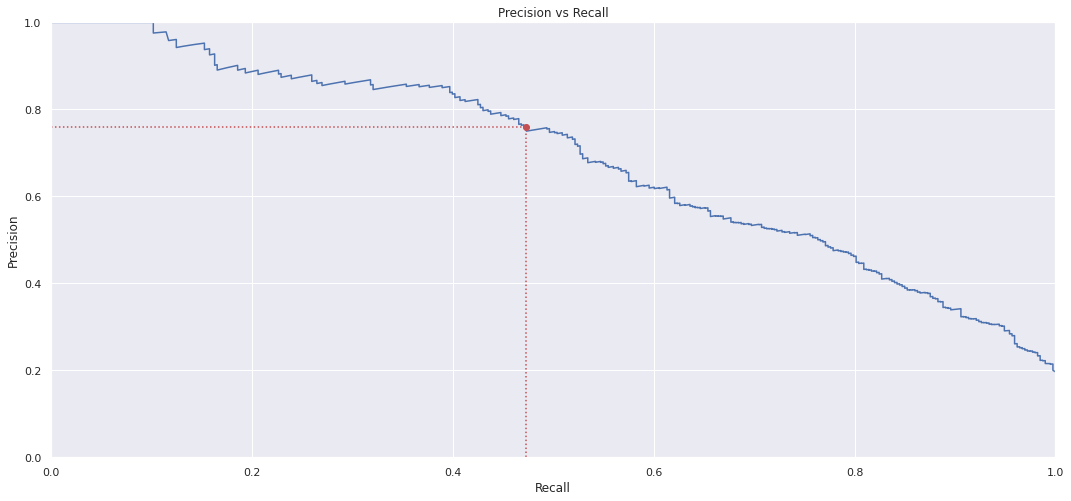

In [31]:
# Graph Precision vs Recall
plt.plot(recalls, precisions);
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])

## Identify model values
plt.plot([model_recall, model_recall], [0.0, model_precision], 'r:');
plt.plot([0.0, model_recall], [model_precision, model_precision], 'r:');
plt.plot([model_recall], [model_precision], 'ro');
plt.title('Precision vs Recall')
plt.show()

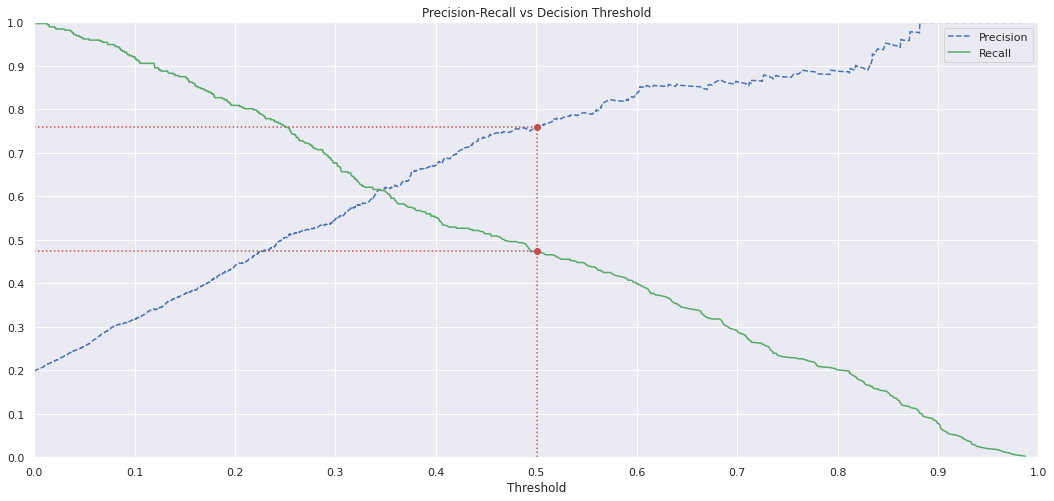

In [32]:
# Graph Precision-Recall vs Threshold
plt.plot(thresholds, precisions[:-1], "b--", label = 'Precision');
plt.plot(thresholds, recalls[:-1], "g-", label = 'Recall');
plt.legend()
plt.xlabel("Threshold")
plt.xticks(np.arange(0, 1.01, step = 0.1));
plt.yticks(np.arange(0, 1.01, step = 0.1));

# Idenfifying precision and recall from the chosen model
plt.plot([model_threshold, model_threshold], [0.0, model_precision], 'r:')
plt.plot([0.0, model_threshold], [model_precision, model_precision], 'r:')
plt.plot([0.0, model_threshold], [model_recall, model_recall], 'r:')
plt.plot([model_threshold], [model_precision], 'ro')
plt.plot([model_threshold], [model_recall], 'ro')
plt.axis([0, 1, 0, 1])
plt.title('Precision-Recall vs Decision Threshold')
plt.show()

### 9.1.2. Cumulative Gains Curve and Lift Curve

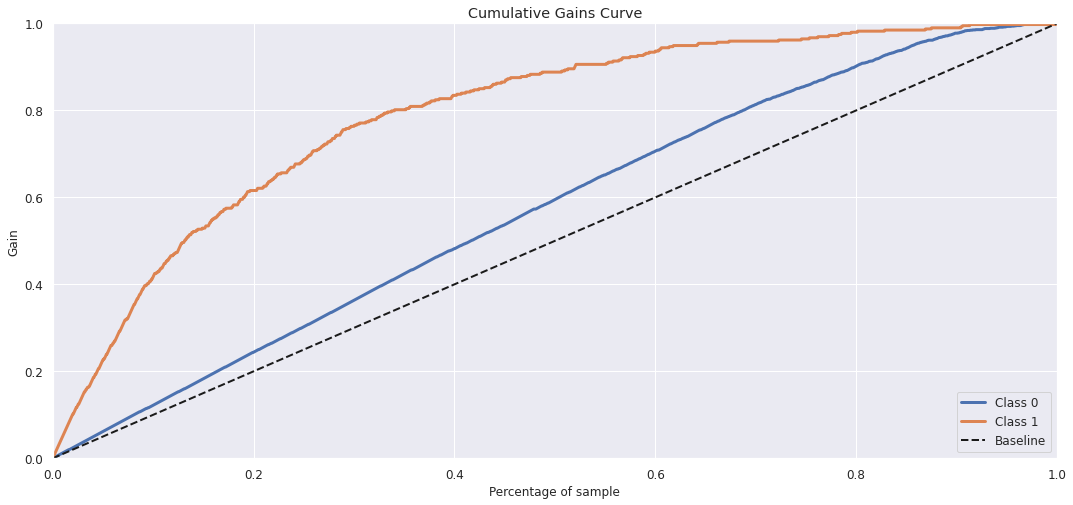

In [33]:
plot_cumulative_gain(y_test, y_probs);

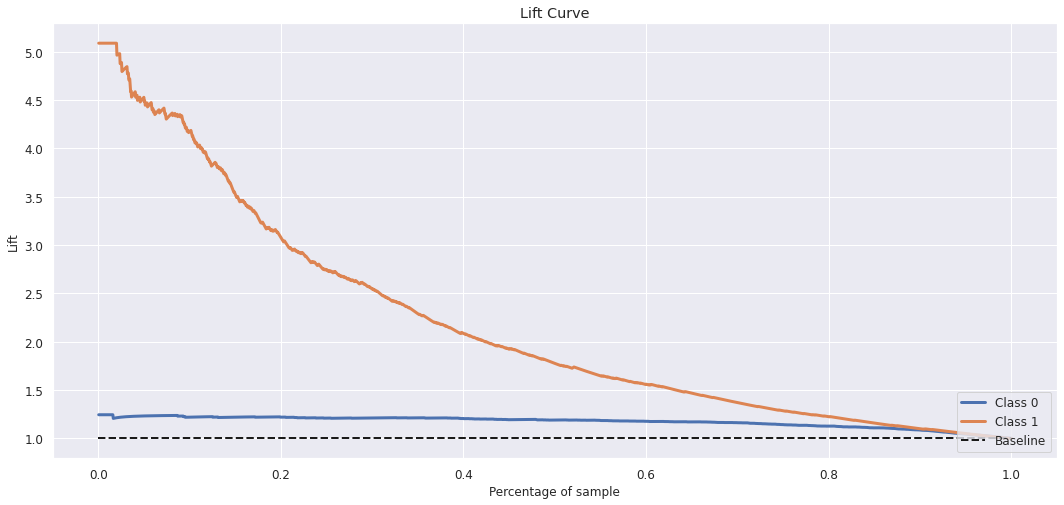

In [34]:
plot_lift_curve(y_test, y_probs);

## 9.2. Business Performance

In [37]:
df_y_test_scores = pd.DataFrame(y_test)
df_y_test_scores['prediction'] = y_hat
df_y_test_scores['prob_churn'] = y_scores

In [38]:
df_business = pd.concat([df4.drop('exited', axis = 1), pd.DataFrame(df_y_test_scores)], axis = 1).dropna()

### 9.2.1. What is the current Churn rate? How does it vary monthly?

In [237]:
churn_rate = df_business['exited'].value_counts(normalize = True) * 100
print('The current Churn rate of the company is {} %'.format(churn_rate[1].round(2)))

The current Churn rate of the company is 19.65 %


Since there's no `datetime` information available in our dataset, it is therefore not possible to calculate how the Churn rate varies monthly. Instead, we can calculate the **churn variation per tenure** (nº of years that the customer was active):

In [227]:
aux = df_business[['tenure', 'exited']].sort_values(by = 'tenure')

tenure_list = aux['tenure'].unique()

churn_list = []
for i in tenure_list:
    df_tenure = aux[aux['tenure'] == i]
    churn_tenure = df_tenure['exited'].sum() / len(df_tenure) * 100
    churn_list.append(churn_tenure.round(2))

df_tenure_churn = pd.DataFrame({'tenure': tenure_list,
                                'churn rate (%)': churn_list})
df_tenure_churn

,tenure,churn rate (%)
0,0,18.75
1,1,19.09
2,2,20.59
3,3,16.83
4,4,26.34
5,5,25.68
6,6,20.00
7,7,11.73
8,8,19.09
9,9,18.98


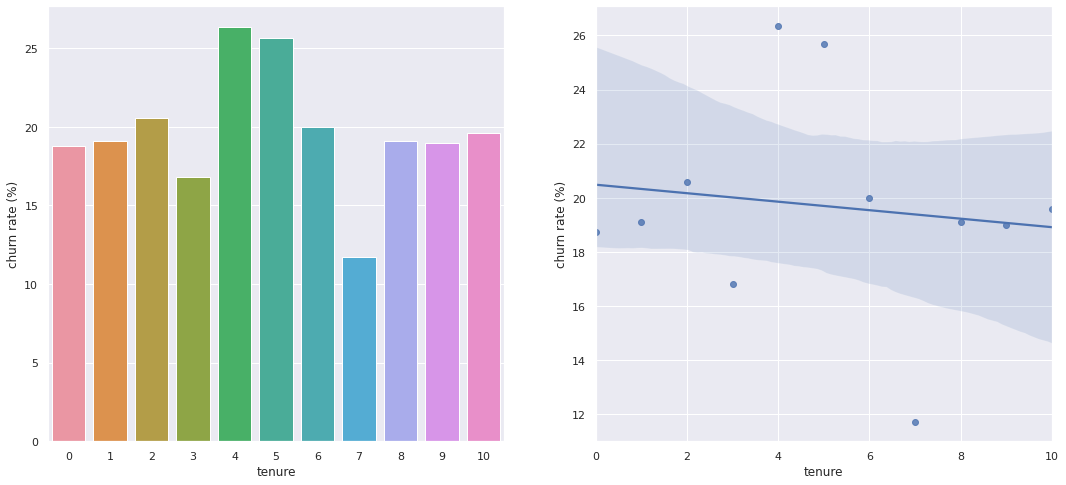

In [228]:
plt.subplot(1, 2, 1)
sns.barplot(x = 'tenure', y = 'churn rate (%)', data = df_tenure_churn);

plt.subplot(1, 2, 2)
sns.regplot(x = 'tenure', y = 'churn rate (%)', data = df_tenure_churn);

### 9.2.2. What is the chosen model's performance in classifying clients as churn?

In [38]:
rf_tuned_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,RandomForest Classifier Tuned,0.867,0.759184,0.473282,0.583072,0.718284


### 9.2.3. What is the expected ROI if the company starts using this model for avoiding client churn?

**A) Calculate profit for test set without model**

Reminders:
- The company makes profit according to a percentage of the estimated salary of each active client;
- If the client receives less than the average of the total estimated salary, the company makes 15 % of its salary as profit;
- If the client receives more than this average, the company makes 20 % of its salary as profit.

In [39]:
mean_salary = df_business['estimated_salary'].mean()

df_business['return_client'] = df_business['estimated_salary'].apply(lambda x: x * 0.15 if x <= mean_salary
                                                          else x * 0.20)

In [240]:
print('The current company profit, without the model, is {:,.2f} €.'.format(df_business['return_client'].sum()))

The current company profit, without the model, is 37,027,524.09 €.


**B) Calculate loss if all clients in Churn leave the bank**

In [42]:
churn_loss = df_business[df_business['exited'] == True]['return_client'].sum()
print('The company loss if clients in Churn leave the bank is {:,.2f} €.'.format(churn_loss))

The company loss if clients in Churn leave the bank is 7,463,041.16 €.


**C)  Calculate ROI, according to: how many clients the model predict right and would allow an action plan to avoid exit?**

Model's recall: from all clients in churn, the model is able to predict **47.33 %** correctly. Therefore:

In [43]:
print('The approximate ROI is {:,.2f} €.'.format(df_business[df_business['exited'] == True]['return_client'].sum() * rf_tuned_result['Recall'][0]))

The approximate ROI is 3,532,126.35 €.


### 9.2.4. Business Plan - Reducing Churn

Provide financial incentives for clients in Churn for making them stay. <br>
Ps.: the sum of the incentives cannot perpass 10,000 €.

**A) Top 100 customers with highest churn probability**

In [293]:
top_100 = df_business.sort_values(by = 'prob_churn', ascending = False)[:100]

In [294]:
expenses = 10000
revenue = top_100['return_client'][top_100['exited'] == 1].sum()

ROI = (revenue - expenses) / expenses * 100
loss_recovered = (revenue / churn_loss) * 100

In [307]:
print('Revenue: € {:,.2f}'.format(revenue))
print('Revenue loss recovered : {:,.2f} %'.format(loss_recovered))
print('Investiment: € {:,.2f}'.format(expenses))
print('ROI: {:,.2f} %'.format(ROI))
print('Potential clients recovered acc. model: {}'.format(top_100['exited'][top_100['exited'] == 1].count()))

Revenue: € 2,557,109.31
Revenue loss recovered : 22.61 %
Investiment: € 10,000.00
ROI: 16,773.52 %
Potential clients recovered acc. model: 89


**B) Maximum returned value with "0-1 Knapsack-Problem" Approach**

- Objetive: select the optimal combination of clients that maximize the total returned value , without exceeding the total weight constraint. <br>
- In this case, each client has a "weight": the financial incentive that will be given in order to avoid the churn. <br>
- The total weight constraint is the total amount available to give the incentives: 10.000 euros. <br>
- The incentive can either be offered or not: 0-1 (0-1 Knapsack).

In [298]:
df_business_knapsack = df_business.copy()

df_business_knapsack['incentive'] = 100
aux = df_business[df_business_knapsack['prediction'] == 1]
aux['incentive'] = 100

In [308]:
# set parameters for knapsack function
val = aux['return_client'].astype(int).values # return per client
wt = aux['incentive'].values # incentive value per client
investiment = 10000 # total amount of incentive according the problem

# calculate revenue with knapsack function
max_val, keep = knapsack(investiment, wt, val)

# dataframe with selected customers that maximizes output value
aux = aux[keep]

# calculate recovered revenue per client
aux['rec_revenue'] = aux.apply(lambda x: x['return_client'] if x['exited'] == 1 
                                    else 0, axis = 1)

# calculate profit per client
aux['profit'] = aux['rec_revenue'] - aux['incentive']

# calculate total recovered revenue
revenue = aux['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / churn_loss)*100

# calculate the amount of investiments (sum of incentives)
expenses = aux['incentive'].sum()

# calculate the profit
profit = aux['profit'].sum()

# calculate ROI
ROI = (profit / expenses) * 100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investiment: {:,.2f}'.format(investiment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(ROI))
print('Potencial clients recovered acc. model: {}'.format(aux['exited'][aux['exited'] == 1].count()))

Recovered Revenue: 2,557,109.31
% Recovered from total Revenue loss: 34.26%
Investiment: 10,000.00
Profit: 2,547,109.31
ROI: 25,471.09%
Potencial clients recovered acc. model: 79


**C) The Realistic Approach and Maximum Returned Value with "0-1 Knapsack Problem" approach**

- Some customers will leave no matter what: p(churn) > 0.99 <br>
- Some might stay but only with a € 200 incentive: 0.95 < p(churn) < 0.99 <br>
- Some will stay with a € 100 incentive: 0.90 < p(churn) < 0.95 <br>
- Others will stay with a € 50 incentive: p(churn) < 0.90

In [40]:
df_business_knapsack_real = df_business.copy()

# list of available incentives
# P.s.: the € 20,000 incentive is for clients with p(churn) > 0.99 (it will be discarded in the knapsack function)
list_possible_incentives = [20000, 200, 100, 50]
list_incentives = []

# set incentive value according to churn prediction probability
for i in range(len(df_business_knapsack_real)):
    entry = df_business_knapsack_real.iloc[i]
    if entry['prob_churn'] >= 0.99:
        list_incentives.append(list_possible_incentives[0])
    elif entry['prob_churn'] >= 0.95 and entry['prob_churn'] < 0.99:
        list_incentives.append(list_possible_incentives[1])
    elif entry['prob_churn'] >= 0.90 and entry['prob_churn'] < 0.95:
        list_incentives.append(list_possible_incentives[2])
    else:
        list_incentives.append(list_possible_incentives[3])
df_business_knapsack_real['incentive'] = list_incentives

In [46]:
# filter customers in churn according model
aux = df_business_knapsack_real[df_business_knapsack_real['prediction'] == 1]

# set parameters for knapsack function
val = aux['return_client'].astype(int).values
wt = aux['incentive'].values
investiment = 10000 # total amount of incentive according the problem

# calculate revenue with knapsack function
max_val, keep = knapsack(investiment, wt, val)

# dataframe with selected clients that maximizes output value
aux = aux[keep]

# calculate recovered revenue per client
aux['rec_revenue'] = aux.apply(lambda x: x['return_client'] if x['exited'] == 1 
                                 else 0, axis = 1)

# calculate profit per client
aux['profit'] = aux['rec_revenue'] - aux['incentive']

# calculate total recovered revenue
revenue = aux['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / churn_loss) * 100

# calculate the amount of investiments (sum of incentives)
investiment = aux['incentive'].sum()

# calculate the profit
profit = aux['profit'].sum()

# calculate ROI
roi = (profit / investiment)*100

# calculate possible churn reduction in %
churn_model = aux[(aux['exited'] == 1) & (aux['prob_churn'] == 1)]
churn_red = (len(churn_model) / len(df_business[df_business['exited'] == 1])) * 100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f} %'.format(loss_recovered))
print('Investiment: {:,.2f}'.format(investiment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f} %'.format(roi))
print('Potencial clients recovered acc. model: {}'.format(len(churn_model)))
print('Potencial churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 3,347,967.06
% Recovered from Total Revenue loss: 44.86 %
Investiment: 10,000.00
Profit: 3,337,967.06
ROI: 33,379.67 %
Potencial clients recovered acc. model: 0
Potencial churn reduction: 0.00%
